In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root = './Data', train = True, transform = transform, download = True)
test_dataset = datasets.MNIST(root = './Data', train = False, transform = transform, download = True)

In [5]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 128, shuffle = True, num_workers = 4, pin_memory = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = True, num_workers = 4)

In [25]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride = 2, padding = 1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride = 2, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride = 2, padding = 0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim = 1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [26]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )
        
        self.unflatten = nn.Unflatten(1, (32, 3, 3))
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride = 2, output_padding = 0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride = 2, padding = 1, output_padding = 1),
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [27]:
encoder = Encoder(encoded_space_dim = 4, fc2_input_dim = 128).to(device)
decoder = Decoder(encoded_space_dim = 4, fc2_input_dim = 128).to(device)

params_to_optimize = [{'params': encoder.parameters()}, {'params': decoder.parameters()}]

optim = torch.optim.Adam(params_to_optimize, lr = 0.001, weight_decay = 1e-05)
loss_fn = torch.nn.MSELoss()


In [28]:
def add_noise(inputs, noise_factor = .3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [29]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor = 0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [30]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor = 0.3):
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [31]:
def plot_ae_outputs(encoder, decoder, n = 5, noise_factor = .3):
    plt.figure(figsize = (10, 4.5))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)
        
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))
            
        plt.imshow(img.cpu().squeeze().numpy(), cmap = 'gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original Image')
        ax = plt.subplot(3, n, i + 1 + n)
        
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap = 'gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Damaged Image with Noise')
        ax = plt.subplot(3, n, i + 1 + n + n)
        
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap = 'gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstruted Image')
    
    plt.subplots_adjust(left = .1, bottom = .1, right = .7, top = .9, wspace = .3, hspace = .3)
    
    plt.show()

Epoch 1 of 30

 EPOCH 1/30 	 train_loss = 0.0715 	 val_loss = 0.0585
Epoch 2 of 30

 EPOCH 2/30 	 train_loss = 0.0599 	 val_loss = 0.0497
Epoch 3 of 30

 EPOCH 3/30 	 train_loss = 0.0546 	 val_loss = 0.0432
Epoch 4 of 30

 EPOCH 4/30 	 train_loss = 0.0526 	 val_loss = 0.0423
Epoch 5 of 30

 EPOCH 5/30 	 train_loss = 0.0519 	 val_loss = 0.0408
Epoch 6 of 30

 EPOCH 6/30 	 train_loss = 0.0514 	 val_loss = 0.0405
Epoch 7 of 30

 EPOCH 7/30 	 train_loss = 0.0511 	 val_loss = 0.0402
Epoch 8 of 30

 EPOCH 8/30 	 train_loss = 0.0509 	 val_loss = 0.0399
Epoch 9 of 30

 EPOCH 9/30 	 train_loss = 0.0507 	 val_loss = 0.0394
Epoch 10 of 30

 EPOCH 10/30 	 train_loss = 0.0506 	 val_loss = 0.0393
Epoch 11 of 30

 EPOCH 11/30 	 train_loss = 0.0505 	 val_loss = 0.0393
Epoch 12 of 30

 EPOCH 12/30 	 train_loss = 0.0504 	 val_loss = 0.0396
Epoch 13 of 30

 EPOCH 13/30 	 train_loss = 0.0502 	 val_loss = 0.0393
Epoch 14 of 30

 EPOCH 14/30 	 train_loss = 0.0502 	 val_loss = 0.0390
Epoch 15 of 30

 EPOCH 1

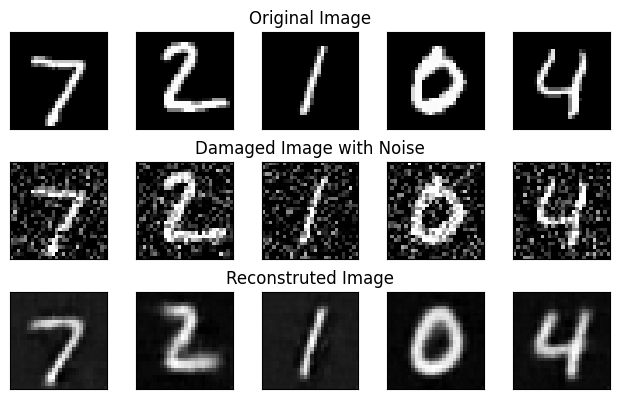

In [32]:
num_epochs = 30
history_da = {'train_loss': [], 'val_loss': []}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} of {num_epochs}')
    train_loss = train_epoch(encoder, decoder, device, train_loader, loss_fn, optim, noise_factor = .3)
    val_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn, noise_factor = .3)
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train_loss = {:.4f} \t val_loss = {:.4f}'.format(epoch + 1, num_epochs, train_loss, val_loss))
plot_ae_outputs(encoder, decoder, n = 5, noise_factor = .3)